# goes-make-ortho-map

This notebook walks through creating a map that relates grid cells from a DEM to the GOES ABI pixels that contain those grid cells, which can then be used to orthorectify GOES ABI products.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

#### Define functions

In [2]:
def ABIangle2LonLat(x, y, H, req, rpol, lon_0_deg):
    '''This function finds the latitude and longitude (degrees) of point P 
    given x and y, the ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    # solve for rc on the ellipsoid
    #_rc = c*cos(A) ± √[ a2 - c2 sin2 (A) ]
    # add elevation z to rc
    # compute new rs value
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat) #*
    lon = lon_0_deg - np.degrees( np.arctan( Sy / ( H - Sx )) )
    
    return (lon,lat)


In [3]:
def LonLat2ABIangle(lon_deg, lat_deg, z, H, req, rpol, e, lon_0_deg):
    '''This function finds the ABI elevation (y) and scanning (x) angles (radians) of point P, 
    given a latitude and longitude (degrees)'''
    
    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)
      
    # geocentric latitude
    lat_geo = np.arctan( (rpol**2 / req**2) * np.tan(lat) )

    # geocentric distance to point on the ellipsoid
    _rc = rpol / np.sqrt(1 - (e**2)*(np.cos(lat_geo)**2)) # this is rc if point is on the ellipsoid
    rc = _rc + z # this is rc if the point is offset from the ellipsoid by z (meters)

    # intermediate calculations
    Sx = H - rc * np.cos(lat_geo) * np.cos(lon - lon_0)
    Sy = -rc * np.cos(lat_geo) * np.sin(lon - lon_0)
    Sz = rc * np.sin(lat_geo)
    
    # calculate x and y scan angles
    y = np.arctan( Sz / Sx )
    x = np.arcsin( -Sy / np.sqrt( Sx**2 + Sy**2 + Sz**2 ) )
    
    ## determine if this point is visible to the satellite
    #condition = ( H * (H-Sx) ) < ( Sy**2 + (req**2 / rpol**2)*Sz**2 )
    #if condition == True:
    #    print('Point at {},{} not visible to satellite.'.format(lon_deg,lat_deg))
    #    return (np.nan, np.nan)
    #else:
    #    return (x,y)
    return (x,y)
    

In [4]:
def calcLookAngles(lon_deg, lat_deg, lon_0_deg):
    
    # convert lat and lon from degrees to radians
    lon = np.radians(lon_deg)
    lat = np.radians(lat_deg)
    lon_0 = np.radians(lon_0_deg)
    
    s = lon_0 - lon
    
    el = np.arctan( ((np.cos(s)*np.cos(lon)) - 0.1512) / (np.sqrt(1 - ((np.cos(s)**2)*(np.cos(lon)**2)))) )
    
    az = np.arctan( np.tan(s)/np.sin(lon) )
    
    return(np.degrees(az) + 180, np.degrees(el))

In [5]:
# NOTE: This function isn't needed for the applying the mapping to a GOES ABI image, 
# but we can still use this to make some visualizations of what we're doing.
def ABIpixelMap(abi_grid_x, abi_grid_y):
    '''
    Converts an array of continuous ABI scan angles into discrete pixel center locations 
    (in scan angle coordinates, incrimenting by the pixel IFOV)
    '''
    # IFOV values for GOES ABI bands ("500 m" 14 urad; "1 km" 28 urad; "2 km" 56 urad)
    ifov=np.array([14e-6, 28e-6, 56e-6])
    
    # Convert from scan angle to pixel row/column coordinates 
    x_px = np.array([np.divide(abi_grid_x,i) for i in ifov])
    y_px = np.array([np.divide(abi_grid_y,i) for i in ifov])

    # Get the center coordinate of the pixel each grid cell lies within
    center_x = ((np.floor(np.abs(x_px))+0.5)*np.sign(x_px)) * ifov[:,None,None]
    center_y = ((np.floor(np.abs(y_px))+0.5)*np.sign(y_px)) * ifov[:,None,None]

    # Get the pixel coordinate (row/column) that each grid cell lies within
    #center_col = (np.floor(x_px))
    #center_row = (np.floor(y_px))

    return center_x, center_y#, center_col, center_row

#### Get inputs

In [6]:
# Values needed for geometry calculations
req = 6378137 #g16_b02.goes_imager_projection.semi_major_axis
rpol = 6356752.31414 #g16_b02.goes_imager_projection.semi_minor_axis
H = 42164160 #g16_b02.goes_imager_projection.perspective_point_height + g16_b02.goes_imager_projection.semi_major_axis
lon_0 = -137.2 #g16_b02.goes_imager_projection.longitude_of_projection_origin
e = 0.0818191910435 # GRS-80 eccentricity

#### Load a DEM from a local file:

Future improvements: Use the elevation library to bring in SRTM DEMs for a region of interest automatically?

In [7]:
dem_filename = 'dem.tif'
dem = xr.open_rasterio(dem_filename) #or grandmesa_dem.tif
dem = dem.where(dem!=dem.nodatavals[0])[0,:,:] # replace nodata with nans
dem = dem.where(dem!=0) # replace zeros with nans
dem

<xarray.DataArray (y: 1501, x: 1995)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band     int32 1
  * y        (y) float64 38.2 38.2 38.19 38.19 38.19 ... 37.73 37.73 37.73 37.73
  * x        (x) float64 -119.8 -119.8 -119.8 -119.8 ... -119.2 -119.2 -119.2
Attributes:
    transform:      (0.0003115924696741881, 0.0, -119.806908765, 0.0, -0.0003...
    crs:            +init=epsg:4326
    res:            (0.0003115924696741881, 0.0003115924696868757)
    is_tiled:       0
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

##### Demo this at a single point:
For a single point on the DEM, determine which ABI pixel it is contained within, taking into account terrain parallax, then find the footprint of that pixel over the terrain

In [8]:
#for lon_0 in [-75.2, -137.2]: # for the locaiton of GOES-East and GOES-West
#    
#    lat = 37.88175
#    lon = -119.31212
#    z = 2811
#    print('\nStarting point lon, lat, z:',lon, lat, z)
#
#    # find corresponding angles
#    x, y = LonLat2ABIangle(lon,lat,z,H,req,rpol,e,lon_0)
#    print('Scan angle x, y:',x, y)
#
#    # use these to go back to our original lon and lat without taking elevation into account
#    _lon, _lat = ABIangle2LonLat(x,y,H,req,rpol,lon_0)
#    print('Erroneous lon, lat:',_lon, _lat)
#
#    print('Offset (km) (E-W, N-S):',(_lon-lon)*111, (_lat-lat)*111)
#    
#    # Convert from scan angle to pixel coordinates for the 56 urad ("2km") pixels 
#    # and get the center of the pixel we're in (back in scan angle coordinates)
#    ifov = 56e-6
#    i = 2 # this selects the center_x and center_y values corresponding with the 56 urad pixels for this demonstration
#    center_x, center_y, center_col, center_row = ABIpixelMap(x, y)
#    print('Pixel coords relative to origin (x,y):',center_col[i],center_row[i])
#    print('The center of this pixel is at (x,y):',center_x[i,0,i],center_y[i,0,i])
#
#
#    # for each grid cell in the DEM, compute the corresponding ABI scan anlge (x and y, radians)
#    X, Y = np.meshgrid(dem.x,dem.y) # Lon and Lat of each DEM grid cell
#    Z = dem.values # elevation of each DEM grid cell
#    abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)
#
#    
#    # Find the ABI pixel that our point is contained within
#    x_cond = (abi_grid_x >= (center_x[i,0,i]-(0.5*ifov))) & (abi_grid_x <= (center_x[i,0,i]+(0.5*ifov)))
#    y_cond = (abi_grid_y >= (center_y[i,0,i]-(0.5*ifov))) & (abi_grid_y <= (center_y[i,0,i]+(0.5*ifov)))
#    # This makes a map of True and False values
#    pixel_of_interest = (x_cond & y_cond)
#    # Now make a map of 1s and Nans to represent where our pixel is
#    pixel_map = np.zeros(pixel_of_interest.shape)
#    pixel_map[pixel_of_interest==True] = 1
#    pixel_map[pixel_of_interest==False] = np.nan
#    
#  
#    # Plot a hillshade of the DEM as seen from geostationary orbit at lon_0
#    plt.figure(figsize=(10,10))
#    plt.plot(abi_grid_x,abi_grid_y,'.',c='grey',markersize=1,alpha=0.02)
#    plt.plot(abi_grid_x[pixel_of_interest],abi_grid_y[pixel_of_interest], alpha=0.3, c='m') # make sure we're looking at the right pixel
#    plt.plot(x,y,'^',c='k',markersize=13) # location of gaylor pit
#    plt.plot(x,y,'^',c='#eaec2c',markersize=10) # location of gaylor pit
#    #plt.plot([center_x-28e-6, center_x+28e-6,center_x+28e-6, center_x-28e-6, center_x-28e-6],
#    #         [center_y+28e-6, center_y+28e-6,center_y-28e-6, center_y-28e-6, center_y+28e-6],':r') # the pixel we're in
#    plt.xlim((x-0.0010,x+0.0004))
#    plt.ylim((y-0.0007,y+0.0007))
#    plt.title('Geostationary Satellite View \nof the Tuolumne River Basin from {}'.format(lon_0))
#    plt.xlabel('ABI Azimuth Scan Angle (rad)')
#    plt.ylabel('ABI Elevation Scan Angle (rad)')
#    #plt.savefig('tuolumne_GOES-R_ABI_parallax_30m_{}_overlay.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')
#    #plt.close()
#    
#    # Plot the pixel we're in overlayed on the DEM
#    plt.figure(figsize=(10,10))
#    plt.imshow(Z,cmap='terrain')
#    plt.colorbar()
#    plt.imshow(pixel_map,alpha=0.3,cmap='spring')
#    plt.title('Elevation (meters) \n and projected pixel footprint as seen from {}'.format(str(lon_0)))
#    #plt.xlim((1500,3000))
#    #plt.ylim((3000,1500))
#    #plt.savefig('tuolumne_GOES-R_ABI_parallax_30m_{}_dem_overlay.png'.format(str(lon_0)),dpi=300,bbox_inches='tight')
#

For the entire DEM, determine what ABI pixel every DEM grid cell belongs to, taking into account terrain parallax

In [9]:
# map every DEM grid cell to a corresponding ABI pixel (using center of pixel scan angle x and y)
lon_0 = -75

# for each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
X, Y = np.meshgrid(dem.x,dem.y) # Lon and Lat of each DEM grid cell
Z = dem.values # elevation of each DEM grid cell

# with parallax
abi_grid_x, abi_grid_y = LonLat2ABIangle(X,Y,Z,H,req,rpol,e,lon_0)
center_x, center_y = ABIpixelMap(abi_grid_x, abi_grid_y) # NOTE: this step is no longer required for our final product

# without parallax
_abi_grid_x, _abi_grid_y = LonLat2ABIangle(X,Y,np.zeros_like(Z),H,req,rpol,e,lon_0)
_center_x, _center_y = ABIpixelMap(_abi_grid_x, _abi_grid_y)  # NOTE: this step is no longer required for our final product

In [10]:
# Calculate look angles
az, el = calcLookAngles(X,Y,lon_0)

##### Demo this for an area (make plots):

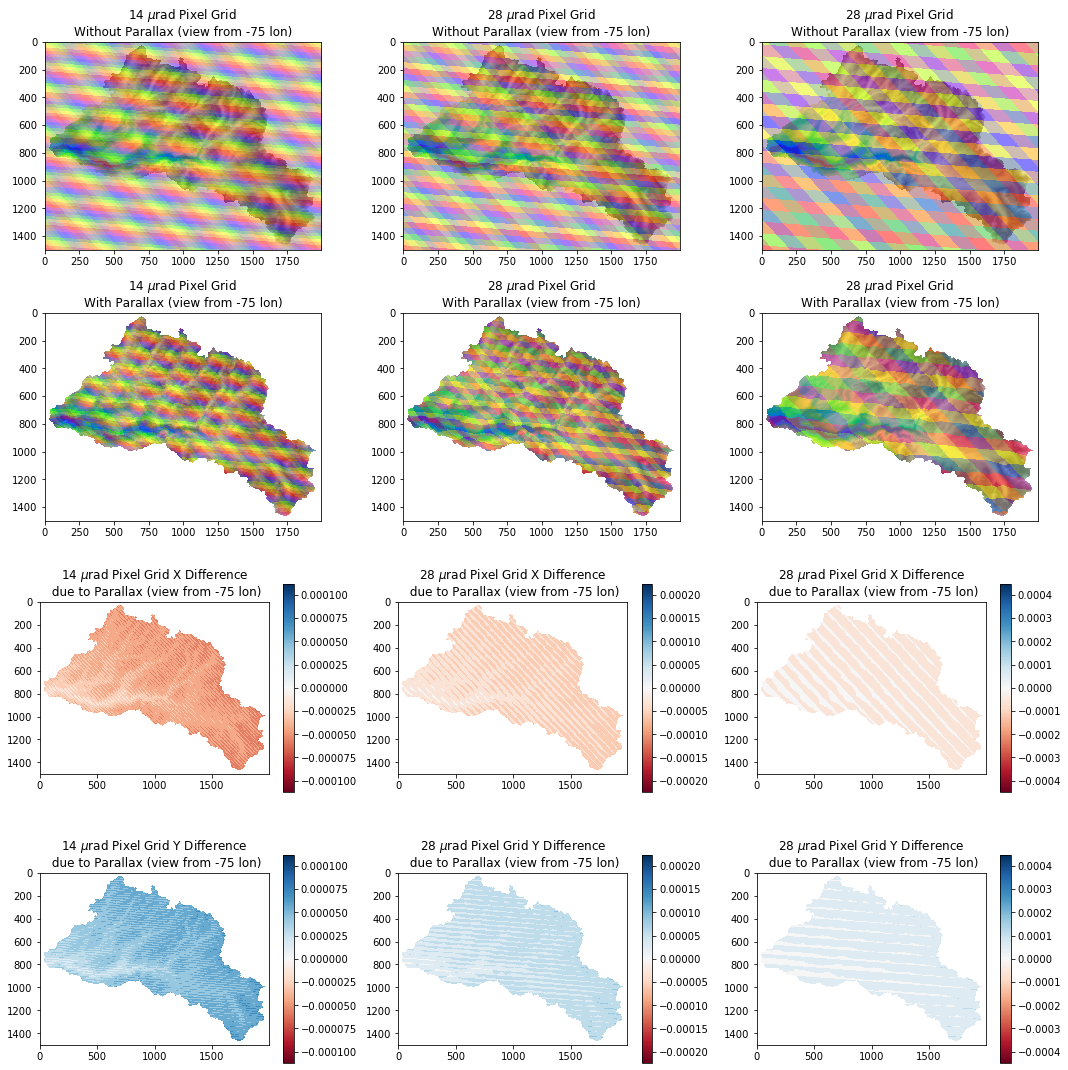

In [11]:
# Plot the original pixel locations over the DEM
fig, ax = plt.subplots(4, 3, figsize=(15,15))

# For the 14 urad pixels ("500 m")
ifov=14e-6
ax[0,0].set_title('14 $\mu$rad Pixel Grid \nWithout Parallax (view from {} lon)'.format(lon_0))
ax[0,0].imshow(Z,cmap='terrain')
ax[0,0].imshow(_center_x[0],cmap='prism',alpha=0.3)
ax[0,0].imshow(_center_y[0],cmap='prism',alpha=0.3)
# Plot the pixels draped over the DEM
ax[1,0].set_title('14 $\mu$rad Pixel Grid \nWith Parallax (view from {} lon)'.format(lon_0))
ax[1,0].imshow(Z,cmap='terrain')
ax[1,0].imshow(center_x[0],cmap='prism',alpha=0.3)
ax[1,0].imshow(center_y[0],cmap='prism',alpha=0.3)
# Plot the difference in X
ax[2,0].set_title('14 $\mu$rad Pixel Grid X Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_x = ax[2,0].imshow(center_x[0] - _center_x[0],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_x, ax=ax[2,0])
# Plot the difference in Y
ax[3,0].set_title('14 $\mu$rad Pixel Grid Y Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_y = ax[3,0].imshow(center_y[0] - _center_y[0],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_y, ax=ax[3,0])


# For the 28 urad pixels ("1 km")
ifov=28e-6
ax[0,1].set_title('28 $\mu$rad Pixel Grid \nWithout Parallax (view from {} lon)'.format(lon_0))
ax[0,1].imshow(Z,cmap='terrain')
ax[0,1].imshow(_center_x[1],cmap='prism',alpha=0.3)
ax[0,1].imshow(_center_y[1],cmap='prism',alpha=0.3)
# Plot the pixels draped over the DEM
ax[1,1].set_title('28 $\mu$rad Pixel Grid \nWith Parallax (view from {} lon)'.format(lon_0))
ax[1,1].imshow(Z,cmap='terrain')
ax[1,1].imshow(center_x[1],cmap='prism',alpha=0.3)
ax[1,1].imshow(center_y[1],cmap='prism',alpha=0.3)
# Plot the difference in X
ax[2,1].set_title('28 $\mu$rad Pixel Grid X Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_x = ax[2,1].imshow(center_x[1] - _center_x[1],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_x, ax=ax[2,1])
# Plot the difference in Y
ax[3,1].set_title('28 $\mu$rad Pixel Grid Y Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_y = ax[3,1].imshow(center_y[1] - _center_y[1],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_y, ax=ax[3,1])


# For the 56 urad pixels ("2 km")
ifov=56e-6
ax[0,2].set_title('28 $\mu$rad Pixel Grid \nWithout Parallax (view from {} lon)'.format(lon_0))
ax[0,2].imshow(Z,cmap='terrain')
ax[0,2].imshow(_center_x[2],cmap='prism',alpha=0.3)
ax[0,2].imshow(_center_y[2],cmap='prism',alpha=0.3)
# Plot the pixels draped over the DEM
ax[1,2].set_title('28 $\mu$rad Pixel Grid \nWith Parallax (view from {} lon)'.format(lon_0))
ax[1,2].imshow(Z,cmap='terrain')
ax[1,2].imshow(center_x[2],cmap='prism',alpha=0.3)
ax[1,2].imshow(center_y[2],cmap='prism',alpha=0.3)
# Plot the difference in X
ax[2,2].set_title('28 $\mu$rad Pixel Grid X Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_x = ax[2,2].imshow(center_x[2] - _center_x[2],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_x, ax=ax[2,2])
# Plot the difference in Y
ax[3,2].set_title('28 $\mu$rad Pixel Grid Y Difference\n due to Parallax (view from {} lon)'.format(lon_0))
diff_y = ax[3,2].imshow(center_y[2] - _center_y[2],vmin=-8*ifov, vmax=8*ifov,cmap='RdBu')
fig.colorbar(diff_y, ax=ax[3,2])


plt.tight_layout()
plt.savefig('Tuolumne_ABIpixelMapping_{}.jpg'.format(lon_0))

Create metadata about this map (should probably clean up metadata, adhere to some set of standards)

For every DEM grid cell (our finest resolution unit of information) we have a:

 - Longitude
 - Latitude
 - ABI scan angle to this grid cell
 - Elevation

In [12]:
# Create metadata dictionary:
metadata = {
            # Information about the projection geometry:
            'longitude_of_projection_origin': lon_0,
            'semi_major_axis': req,
            'semi_minor_axis': rpol,
            'satellite_height': H,
            'grs80_eccentricity': e,
    
            'longitude_of_projection_origin_info': 'longitude of geostationary satellite orbit',
            'semi_major_axis_info': 'semi-major axis of GRS 80 reference ellipsoid',
            'semi_minor_axis_info': 'semi-minor axis of GRS 80 reference ellipsoid',
            'satellite_height_info': 'distance from center of ellipsoid to satellite (perspective_point_height + semi_major_axis_info)',
            'grs80_eccentricity_info': 'eccentricity of GRS 80 reference ellipsoid',

            # Information about the DEM source file
            'dem_file': dem_filename,
            'dem_crs' : dem.crs,
            'dem_transform' : dem.transform,
            'dem_res' : dem.res,
            'dem_ifov': -9999, # TO DO
    
            'dem_file_info': 'filename of dem file used to create this mapping',
            'dem_crs_info' : 'coordinate reference system from DEM geotiff',
            'dem_transform_info' : 'transform matrix from DEM geotiff', 
            'dem_res_info' : 'resolution of DEM geotiff',
            'dem_ifov_info': 'instantaneous field of view (angular size of DEM grid cell)',
    
            # For each DEM grid cell, we have...
            'dem_px_angle_x_info': 'DEM grid cell X coordinate (east/west) scan angle in the ABI Fixed Grid',
            'dem_px_angle_y_info': 'DEM grid cell Y coordinate (north/south) scan angle in the ABI Fixed Grid',
            'longitude_info': 'longitude from DEM file',
            'latitude_info': 'latitude from DEM file',
            'elevation_info': 'elevation from DEM file'
}

Export this pixel map along with the metadata (NetCDF with xarray)

In [13]:
ds = xr.Dataset({    
                'elevation':          (['y', 'x'], dem.values)
                },
    
                coords={'longitude':  (['x'], dem.x),
                        'latitude':   (['y'], dem.y),
                        'dem_px_angle_x':     (['y', 'x'],  abi_grid_x),
                        'dem_px_angle_y':     (['y', 'x'],  abi_grid_y)},
                
                attrs=metadata)
                 
ds.to_netcdf('test_map_tuol_2019.nc',mode='w')

Open it and test it out:

<xarray.Dataset>
Dimensions:         (x: 1995, y: 1501)
Coordinates:
    longitude       (x) float64 ...
    latitude        (y) float64 ...
    dem_px_angle_x  (y, x) float64 ...
    dem_px_angle_y  (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    elevation       (y, x) float64 ...
Attributes:
    longitude_of_projection_origin:       -89.5
    semi_major_axis:                      6378137
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    semi_major_axis_info:                 semi-major axis of GRS 80 reference...
    semi_minor_axis_info:                 semi-minor axis of GRS 80 reference...
    satellite_height_info:                distance from center of ellipsoid t...
    grs80_eccentricity_info:              eccentricity of GRS 80 reference el...
    dem_f

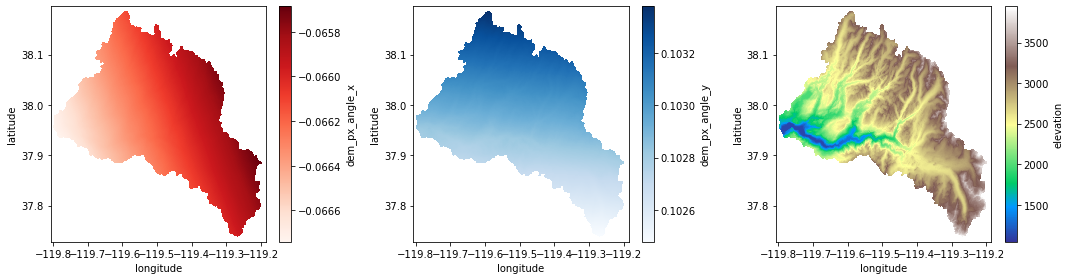

In [14]:
with xr.open_dataset('test_map_tuol_2017.nc') as tuol_test:
    print(tuol_test)

    fig, ax = plt.subplots(1,3,figsize=(15,4))
    tuol_test.dem_px_angle_x.plot(x='longitude',y='latitude',cmap='Reds',ax=ax[0])
    tuol_test.dem_px_angle_y.plot(x='longitude',y='latitude',cmap='Blues',ax=ax[1])
    tuol_test.elevation.plot(x='longitude',y='latitude',cmap='terrain',ax=ax[2])
    plt.tight_layout()

***
***

### TO DO: What about parts of the land surface we can't see?
Try to plot only 30 m DEM grid cells that overlap (meaning that they're obscured form view)

To find where the ground surface is occluded by other terrain (so that we can mask it out), we can look for DEM grid cells that have ABI fixed grid coordinates that overlap with another DEM grid cell. 

In other words...

The only DEM grid cells that are visible to the ABI, are those closest to the lat/lon origin (equator at lon_0) with each set of unique ABI scan angle coordinates (x, y).

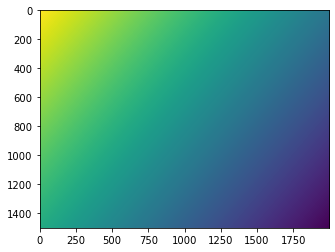

In [112]:
distance_to_lon0_lat0 = np.sqrt( np.abs(ds.longitude - lon_0)**2 + (ds.latitude - 0)**2 ).T
plt.imshow(distance_to_lon0_lat0)

In [200]:
ds['distance_to_lon0_lat0'] = distance_to_lon0_lat0

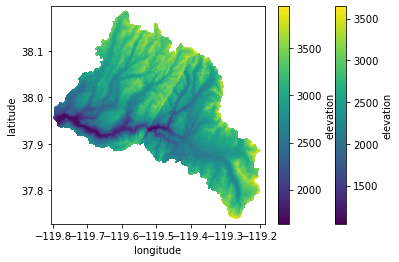

In [245]:
ds.elevation.where(ds.distance_to_lon0_lat0 > ds.distance_to_lon0_lat0.mean()).plot(x='longitude',y='latitude')

ds.elevation.where(ds.distance_to_lon0_lat0 < ds.distance_to_lon0_lat0.mean()).plot(x='longitude',y='latitude')

In [ ]:
xy = np.sqrt( ds.dem_px_angle_x**2 + ds.dem_px_angle_y**2 )


In [443]:
x = np.array([[0,0,0], [2,0,4], [3,1,5]])
y = np.array([[0,0,0], [2,1,4], [3,1,5]])
xy = np.array([x, y])
print(xy)
print(xy.shape)
u, c = np.unique(xy, axis=2, return_counts=True)
print(u)
print(u.shape)
print(c)

[[[0 0 0]
  [2 0 4]
  [3 1 5]]

 [[0 0 0]
  [2 1 4]
  [3 1 5]]]
(2, 3, 3)
[0 1 2 3 4 5]
(6,)
[7 3 2 2 2 2]


In [637]:
i = 6
x = np.round(ds.dem_px_angle_x.values,i)[900:910,400:410]
y = np.round(ds.dem_px_angle_y.values,i)[900:910,400:410]
xy = np.array([x,y])
xy[np.isnan(xy)]=-9999

In [685]:
xy

array([[[-0.091135, -0.091134, -0.091134, -0.091133, -0.091132,
         -0.091132, -0.091131, -0.09113 , -0.09113 , -0.091129],
        [-0.091135, -0.091135, -0.091134, -0.091133, -0.091133,
         -0.091132, -0.091131, -0.091131, -0.09113 , -0.091129],
        [-0.091136, -0.091135, -0.091134, -0.091134, -0.091133,
         -0.091132, -0.091132, -0.091131, -0.09113 , -0.09113 ],
        [-0.091136, -0.091136, -0.091135, -0.091134, -0.091134,
         -0.091133, -0.091132, -0.091132, -0.091131, -0.09113 ],
        [-0.091137, -0.091136, -0.091135, -0.091135, -0.091134,
         -0.091134, -0.091133, -0.091132, -0.091132, -0.091131],
        [-0.091138, -0.091137, -0.091136, -0.091136, -0.091135,
         -0.091134, -0.091133, -0.091133, -0.091132, -0.091132],
        [-0.091138, -0.091138, -0.091137, -0.091136, -0.091135,
         -0.091135, -0.091134, -0.091133, -0.091133, -0.091132],
        [-0.091139, -0.091138, -0.091137, -0.091137, -0.091136,
         -0.091135, -0.091135, -0

In [ ]:
for r in range(xy.shape[1]):
    for c in range(xy.shape[2]):
        _x = xy[0,r,c]
        _y = xy[1,r,c]

In [677]:
def find_dist(xy):
    dist = []
    for r in range(xy.shape[1]):
        for c in range(xy.shape[2]):
            _x = xy[0,r,c]
            _y = xy[1,r,c]
            dist.append(np.sqrt( (xy[0,:,:]-_x)**2 + (xy[1,:,:]-_y)**2 ))
    return np.array(dist)

In [679]:
dist = find_dist(xy)
print(dist.shape)

(100, 10, 10)


In [692]:
np.min(dist,axis=0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

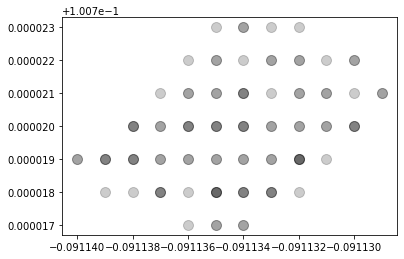

In [604]:
plt.plot(xy[0],xy[1],'ok',alpha=0.2, markersize=10);

In [548]:
for xs in xy:
    for ys in xs:
        print(xy[])

(1501, 1995)
(1501, 1995)


In [544]:
u, c1 = np.unique(xy, axis=1, return_counts=True)
u, c2 = np.unique(u, axis=2, return_counts=True)
print(u.shape)
u[u == -9999] = np.nan
plt.figure(figsize=(20,20))
plt.plot(u[0],u[1],'.k',alpha=0.02);

(2, 1435, 1922)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1435 but corresponding boolean dimension is 1922

<Figure size 1440x1440 with 0 Axes>

In [502]:
u.shape

(2, 1501, 1995)

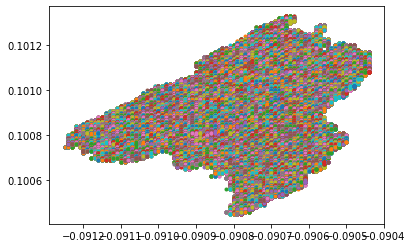

In [494]:
plt.plot(u[0],u[1],'.k',alpha=0.02);

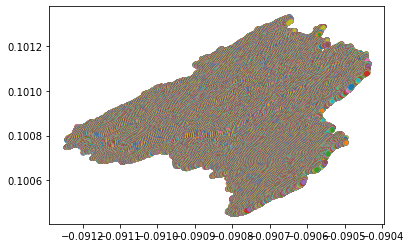

In [450]:
plt.plot(x,y,'.');

In [388]:
print(ds.dem_px_angle_x.values.ravel().shape)

i = 8

# x mask
a = np.round(ds.dem_px_angle_x,i)

u, c = np.unique(a, return_counts=True)
print(u.shape)
dup = u[c > 10]

x_mask = a.isin(dup)
plt.figure(figsize=(10,10))
x_mask.plot(x='longitude',y='latitude')

#################################################
# y mask
a = np.round(ds.dem_px_angle_y,i)

u, c = np.unique(a, return_counts=True)
print(u.shape)
dup = u[c > 10]

y_mask = a.isin(dup)
plt.figure(figsize=(10,10))
y_mask.plot(x='longitude',y='latitude')

################################

# combine masks
mask = np.logical_and(x_mask, y_mask)
plt.figure(figsize=(10,10))
mask.plot(x='longitude',y='latitude')

(2994495,)
(1827366,)
(1833093,)


Error in callback <function flush_figures at 0x0000020C77FCD6A8> (for post_execute):


KeyboardInterrupt: 

(0.1007, 0.100825)

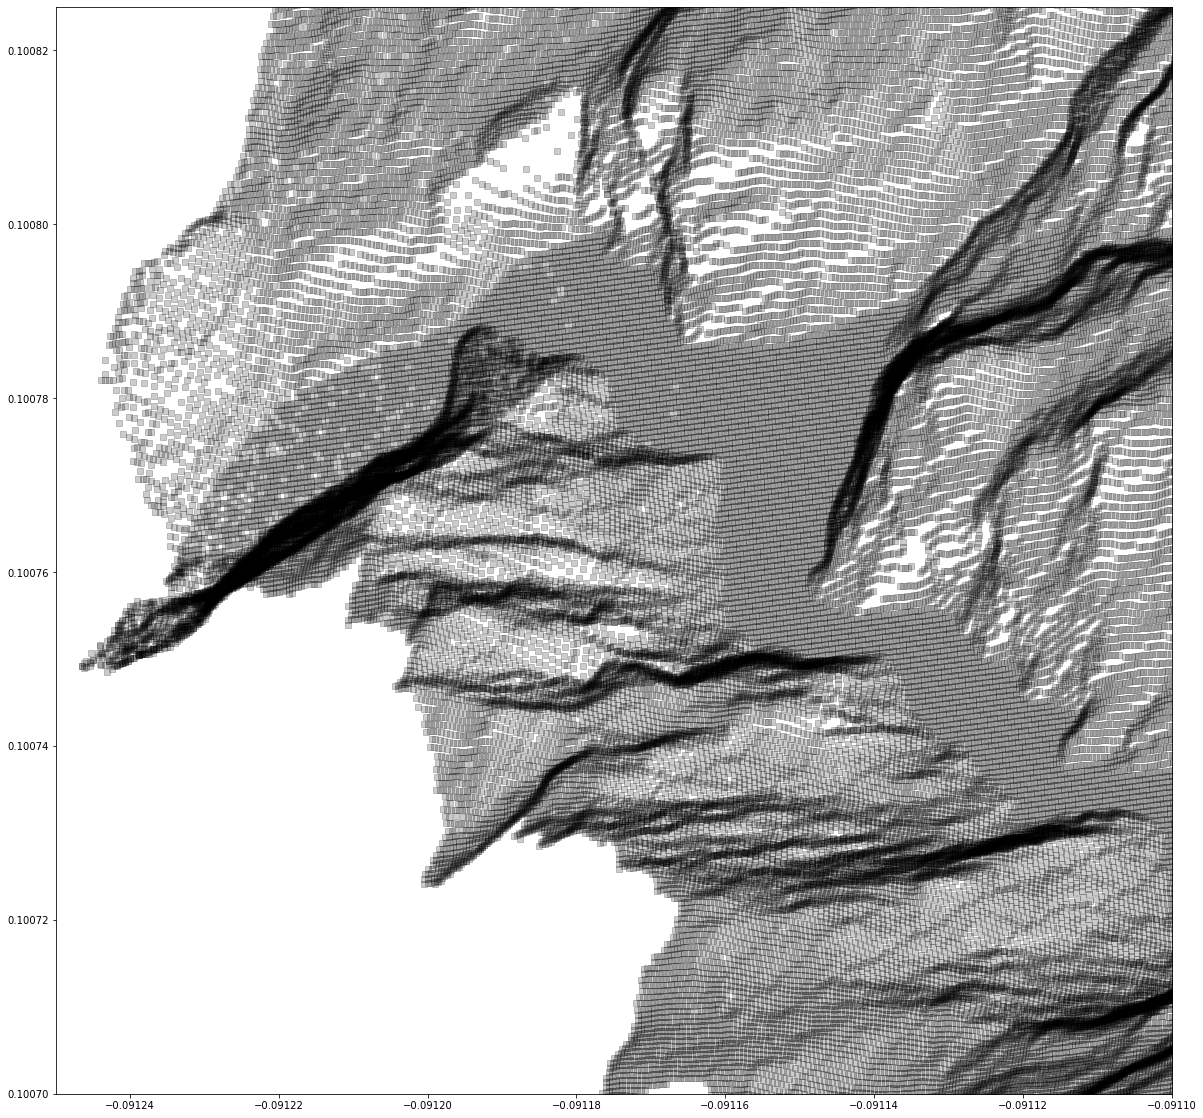

In [378]:
plt.figure(figsize=(20,20))
plt.plot(ds.dem_px_angle_x.where(mask),ds.dem_px_angle_y.where(mask),'sk',alpha=0.2,markersize=6);
plt.xlim((-0.09125,-0.0911))
plt.ylim((0.1007,0.100825))

Compute the approximate IFOV for DEM grid cells

In [ ]:
dem_ifov = (abi_ifov / abi_res) * dem_res

In [299]:
(14/500) * 30

0.84

(0.1007, 0.100825)

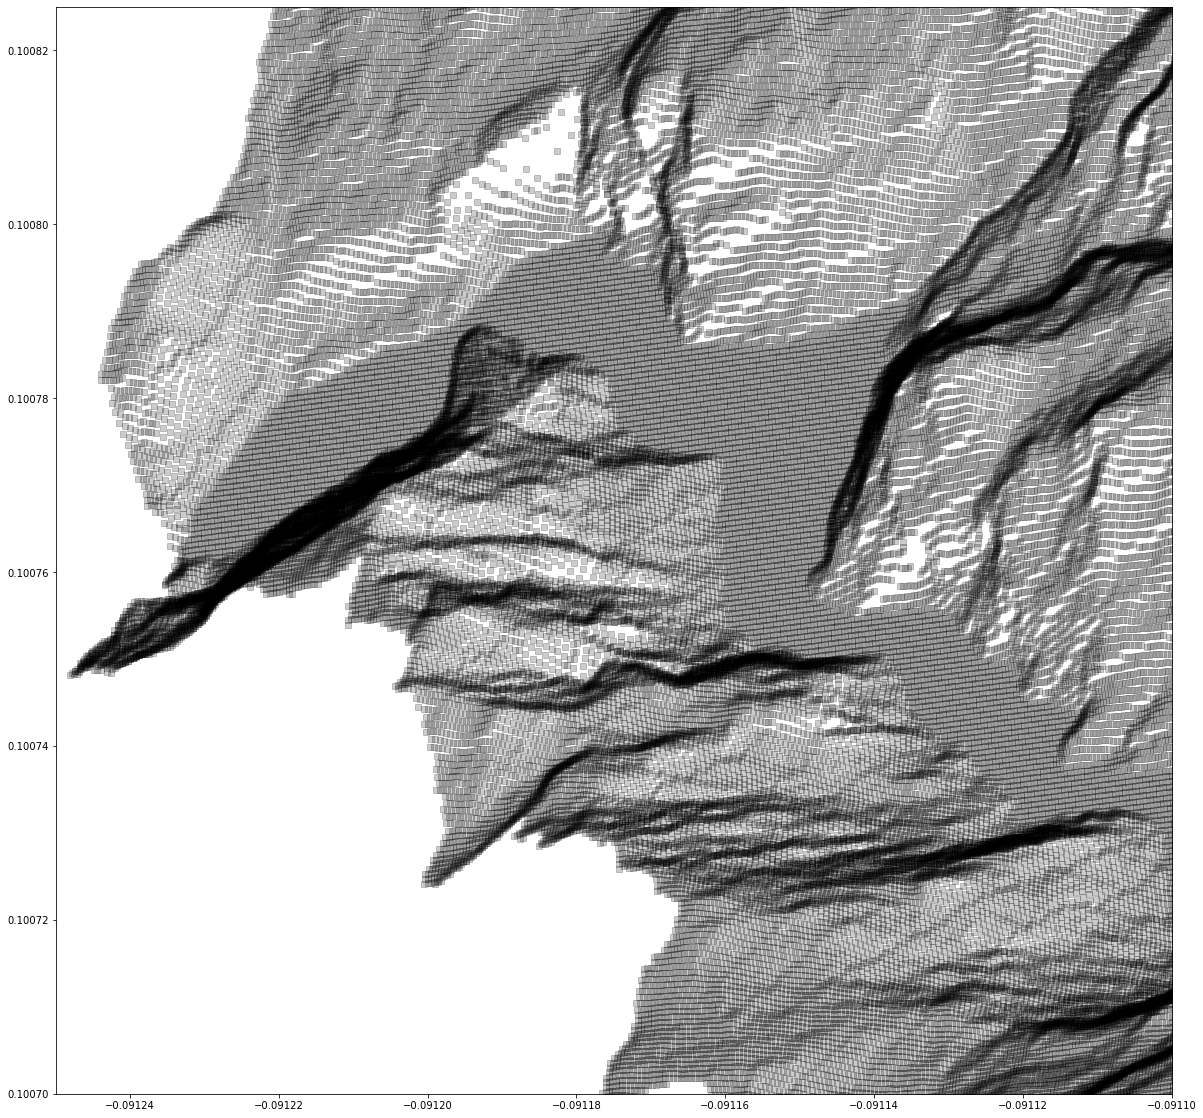

In [316]:
i = 8 # 1 microradian is 10^-6, which is approx the size of the dem_ifov ?
plt.figure(figsize=(20,20))
plt.plot(np.round(ds.dem_px_angle_x,i),np.round(ds.dem_px_angle_y,i),'sk',alpha=0.2,markersize=6);
plt.xlim((-0.09125,-0.0911))
plt.ylim((0.1007,0.100825))

In [584]:
def hillshade(array,azimuth_angle,elevation_angle):
    ''' Create a hillshade given an array of elevations, azimuth, and elevation angle of the light source
    adapted from https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py'''
    azimuth = 360.0 - azimuth_angle 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    elevationrad = elevation_angle*np.pi/180.

    shaded = np.sin(elevationrad)*np.sin(slope) + np.cos(elevationrad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

In [721]:
hs = hillshade(ds.elevation,az,el)

In [730]:
az

array([[10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344],
       [10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344],
       [10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344],
       ...,
       [10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344],
       [10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344],
       [10264.3801219 , 10264.38051912, 10264.38091633, ...,
        10265.17064054, 10265.17103699, 10265.17143344]])

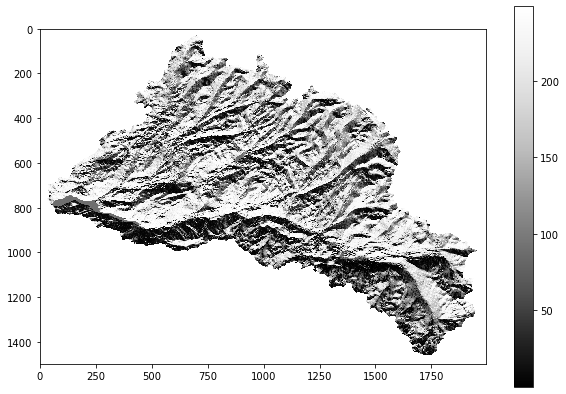

In [722]:
plt.figure(figsize=(10,7))
plt.imshow(hs,cmap='Greys_r')#,vmin=220,vmax=255)
#plt.imshow(hs,cmap='spring',vmin=0,vmax=10,alpha=0.7)
plt.colorbar()
#plt.xlim((50,200))
#plt.ylim((850,650))

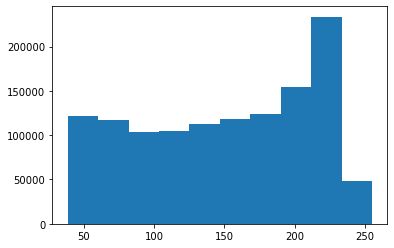

In [608]:
plt.hist(hs.ravel());

it's not np.diff that I want to use, that only finds DEM grid cells that overlap their neighbor, whereas I need to know if a DEM grid cell is overlapped by **any** other grid cell, not neccessarily those adjacent to it.

In [90]:
# Compute differences in x and y coordinates along both axes.
#
# But use the absolute value of the grid values, so that positive values correspond to compressed grid cells
# and negative difference values correspond to stretched grid cells.
#
# Also, throw out the extra row/column so that they're the same shape in the end
# starting off as an array of shape (n, m), ending as (n-1, m-1).

# how far apart in the x direction?
x0_diff = np.diff(np.abs(abi_grid_x),axis=0)[:,:-1] # compute down array
x1_diff = np.diff(np.abs(abi_grid_x),axis=1)[:-1,:] # compute across array

# how far apart in the y direction?
y0_diff = np.diff(np.abs(abi_grid_y),axis=0)[:,:-1] # compute down array 
y1_diff = np.diff(np.abs(abi_grid_y),axis=1)[:-1,:] # compute across array

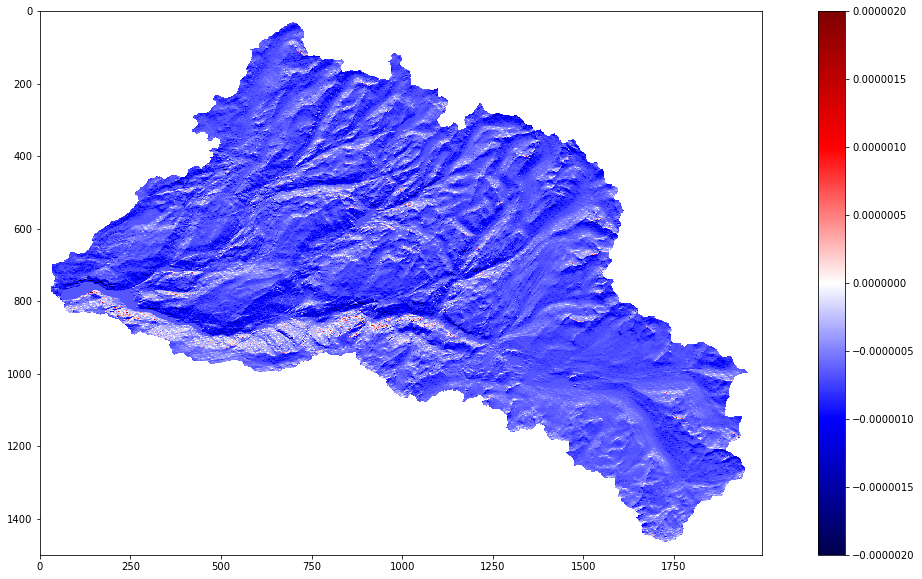

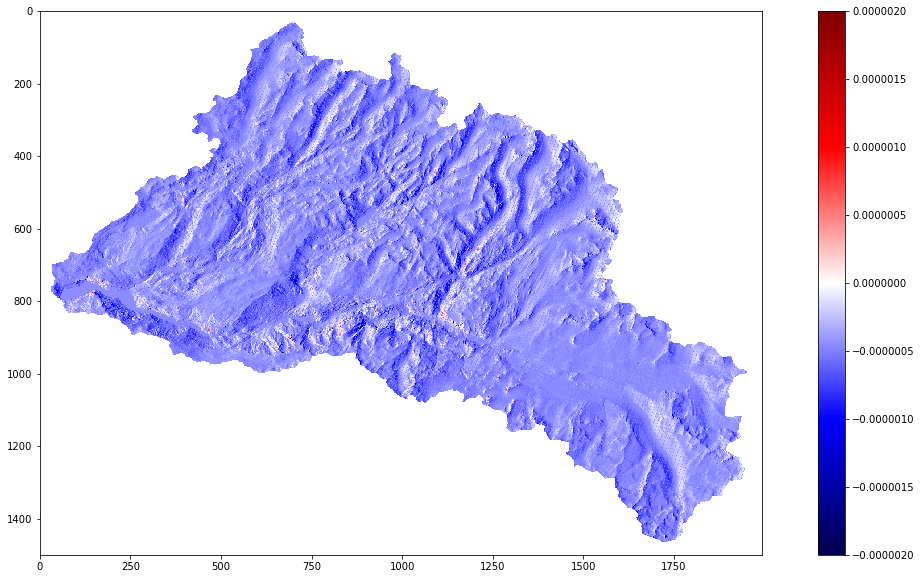

In [91]:
# it looks like where y0_diff is positive, that's where we have hidden terrain
plt.figure(figsize=(20,10))
plt.imshow(y0_diff, cmap='seismic', vmin=-0.000002, vmax=0.000002)
plt.colorbar()

#plt.figure(figsize=(20,10))
#plt.imshow(y1_diff, cmap='seismic', vmin=-0.000002, vmax=0.000002)
#plt.colorbar()

#plt.figure(figsize=(20,10))
#plt.imshow(x0_diff, cmap='seismic', vmin=-0.000002, vmax=0.000002)
#plt.colorbar()

# it looks like where x1_diff is positive, that's where we have hidden terrain
plt.figure(figsize=(20,10))
plt.imshow(x1_diff, cmap='seismic', vmin=-0.000002, vmax=0.000002)
plt.colorbar()

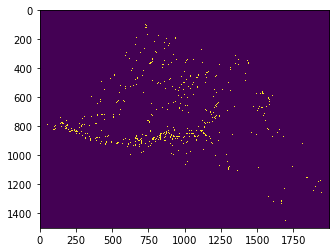

In [92]:
x_mask = np.where((x1_diff>0), 0, 1) # creating a mask for x, where grid cells are overlapping
y_mask = np.where((y0_diff>0), 0, 1) # creating a mask for y, where grid cells are overlapping

# combine all masks by multiplying
terrain_occlusion_mask = x_mask * y_mask

terrain_occlusion_mask = np.where((terrain_occlusion_mask==1), -9999, 0)
plt.imshow(terrain_occlusion_mask)


In [93]:
import rasterio as rio
# Open and write to this new file
with rio.open('gm_test-terrain_occlusion_mask_goes-east.tif', 
              'w', 
              driver='GTiff',
              height=terrain_occlusion_mask.shape[0],
              width=terrain_occlusion_mask.shape[1],
              count=1, 
              dtype='int32',
              nodata=-9999,
              crs=dem.crs, 
              transform=dem.transform) as dst:

    dst.write(terrain_occlusion_mask.astype(int), 1)



***
***